In [1]:
import pandas as pd
import struct
import numpy as np
import struct
import os
from time import time
import matplotlib.pyplot as plt # not needed if you don't want to plot
import pickle
import warnings
import sys
import gzip
import json
from scipy.interpolate import interp2d
from scripts import *
from material import *
from scipy.stats import norm
starting_dir = os.getcwd()

# RFR imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Load the gamma transmission curve data
This represents the fraction of gammas emitted within the TRISO particles that successfully make it out of the pebble's outer surface without scattering or being absorbed. This was determined with Serpent.

An example of what the Serpent input looks like can be seen at "pebble_outward_current_runs/channel_100.inp," although the entire set of inputs and outputs are not included in this repo.

The full generation and execution of these files is done with "gen_pebble_outward-current.py" and "run_pebble_outward_current.py" in the "batch_scripts" directory.

In [2]:
transmission_curve = pd.read_csv("pebble_outward_current_runs/pebble_outward_current_data.csv", index_col=0)

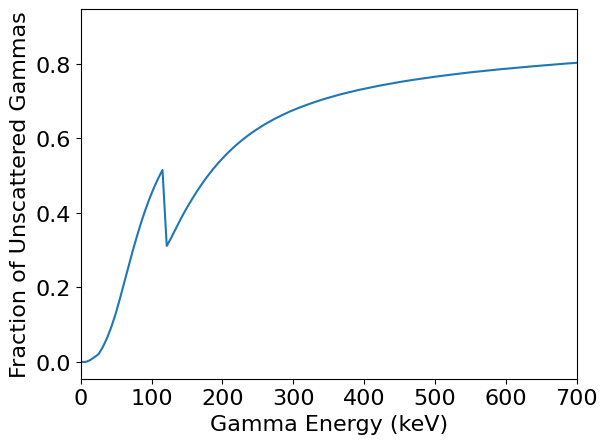

In [58]:
plt.rcParams.update({'font.size': 16})
plt.figure()
plt.plot(transmission_curve["energy"], transmission_curve["efficiency"])
plt.xlabel("Gamma Energy (keV)")
plt.ylabel("Fraction of Unscattered Gammas")
plt.xlim(0,700)
#plt.ylim(0,0.2)
plt.savefig("figures/transmission_curve.png")
plt.show()


# Read Pebble Nuclide and History Data from HxF
Nuclide data from HxF is stored in binary restart files. For portability, this nuclide data and the corresponding history parameters have been extracted and stored in .csv formats. Due to their large size, they are stored on Zenodo and must be added manually to the "hxf_data" directory. 

Variations with the nuclides identified with ZAID and with both 0 and 36 hours of decay have been provided.

In [4]:
conc_file_name = "hxf_data/equilibrium_pebble_concentrations_36h_decay.csv"
history_file_name = "hxf_data/targets.csv"

all_history_data = pd.read_csv(history_file_name, index_col=0)
all_isotopic_data = pd.read_csv(conc_file_name, index_col=0)

In [5]:
display(all_isotopic_data.iloc[0:10])
print(all_isotopic_data.shape)
display(all_history_data.iloc[0:10])
print(all_history_data.shape)

,H-1,H-2,H-3,He-3,He-4,He-6,Li-6,Li-7,Li-8,Li-9,...,Cm-248,Cm-249,Cm-250,Cm-251,Bk-249,Bk-250,Bk-251,Cf-249,Cf-250,Cf-251
0,7.190149e-11,7.192743e-13,7.572559e-16,4.979841e-17,1.527327e-06,0.0,3.143099e-26,2.154870e-26,0.0,0.0,...,1.385481e-10,8.507323e-26,2.377658e-17,2.606775e-61,2.778928e-12,8.397209e-26,1.261795e-33,2.329812e-13,1.809960e-23,6.929699e-19
1,7.351283e-10,8.705802e-11,9.044587e-15,1.642723e-15,9.932194e-08,0.0,5.000120e-24,1.988867e-25,0.0,0.0,...,1.691636e-14,1.045226e-30,1.725052e-21,1.312018e-65,1.618339e-16,6.092397e-30,6.354894e-38,1.132768e-17,8.928414e-28,2.382367e-23
2,2.841051e-11,2.599747e-13,1.023204e-17,5.899400e-20,1.715876e-07,0.0,9.168541e-26,4.115132e-31,0.0,0.0,...,3.432263e-15,2.948922e-31,1.554866e-22,1.246012e-66,2.807349e-17,2.321335e-34,6.035256e-39,1.626712e-18,8.354409e-29,3.044423e-24
3,1.819937e-11,2.686538e-13,1.367943e-16,6.949981e-19,4.359493e-07,0.0,3.937724e-23,2.139816e-27,0.0,0.0,...,1.772115e-14,8.424641e-30,1.070616e-21,1.132928e-65,1.565118e-16,3.781114e-30,5.487171e-38,7.561496e-18,5.254791e-28,2.264367e-23
4,8.301821e-11,6.931703e-13,3.256251e-16,1.028365e-18,9.372575e-07,0.0,2.848388e-26,8.335758e-27,0.0,0.0,...,4.012124e-13,5.159335e-28,2.121492e-20,2.754893e-64,2.886491e-15,7.492506e-29,1.333703e-36,2.087938e-16,1.584349e-26,5.088201e-22
5,3.575526e-11,3.434656e-13,6.004985e-18,3.199875e-20,3.764240e-07,0.0,2.378002e-26,9.609537e-32,0.0,0.0,...,9.885088e-13,8.891298e-29,1.612205e-19,1.462298e-63,1.868895e-14,5.693856e-28,7.082944e-36,1.432723e-15,1.082858e-25,4.109409e-21
6,5.280127e-11,6.398604e-13,6.352000e-16,7.861762e-17,5.762475e-07,0.0,3.370864e-26,6.957499e-27,0.0,0.0,...,6.071329e-13,7.425954e-29,1.047546e-19,7.966929e-64,1.092757e-14,3.699639e-28,3.858871e-36,1.051340e-15,7.713934e-26,2.779767e-21
7,1.001829e-09,5.612617e-12,1.860635e-15,9.606685e-17,7.276282e-08,0.0,1.767844e-22,2.142836e-27,0.0,0.0,...,1.158821e-16,5.683470e-32,3.256096e-24,4.345364e-68,4.631287e-19,4.848737e-36,2.103660e-40,1.319066e-20,9.818816e-31,3.196509e-26
8,8.684058e-12,9.429726e-14,2.246685e-18,1.207587e-20,1.247796e-07,0.0,4.387188e-27,1.818591e-32,0.0,0.0,...,4.128891e-17,2.155391e-33,6.285746e-25,4.086667e-69,2.012919e-19,9.384034e-37,1.381325e-41,6.179444e-21,2.100552e-31,6.356972e-27
9,5.818436e-11,3.925853e-13,9.134889e-18,5.504013e-20,1.200252e-06,0.0,1.010082e-26,3.163566e-32,0.0,0.0,...,1.121432e-11,2.921933e-27,1.231273e-18,6.750956e-62,1.926277e-13,4.348512e-27,3.270072e-34,1.875560e-14,9.296364e-25,4.621329e-20


(15744, 1349)


,U-235,U-238,Pu-239,Np-239,avg_r_dist,passes,residence_time,burnup,fima,pass_residence_time,pass_avg_r_dist,pass_fima,pass_burnup,integrated_flux_pebbles_thermal,integrated_flux_pebbles_fast,integrated_power_pebbles,pass_integrated_flux_pebbles_thermal,pass_integrated_flux_pebbles_fast,pass_integrated_power_pebbles
0,0.000843,0.016934,0.000319,0.000008,79.461573,9,591.088235,181.180481,0.187505,65.25,65.358852,0.016711,16.222275,5.068425e+21,1.291933e+22,5.294337e+10,5.838649e+20,1.654441e+21,4.738290e+09
1,0.002407,0.018186,0.000279,0.000006,74.339251,3,199.588235,87.736923,0.091351,65.25,95.549504,0.022884,21.983086,1.794469e+21,5.212669e+21,2.562465e+10,5.196805e+20,1.437061e+21,6.421173e+09
2,0.002175,0.018005,0.000262,0.000004,95.277400,4,261.000000,101.292244,0.105432,65.25,105.362699,0.022979,22.100830,2.228510e+21,5.980395e+21,2.959356e+10,5.592217e+20,1.283165e+21,6.455237e+09
3,0.002069,0.018054,0.000275,0.000008,76.746085,4,261.000000,103.886337,0.108020,65.25,69.571302,0.022459,21.561348,2.273353e+21,5.954343e+21,3.034642e+10,5.691138e+20,1.645897e+21,6.297878e+09
4,0.001543,0.017565,0.000305,0.000006,88.306058,6,391.500000,134.842834,0.139957,65.25,81.341095,0.019043,18.368851,3.203226e+21,8.279488e+21,3.939219e+10,5.359111e+20,1.558171e+21,5.365089e+09
5,0.001340,0.017567,0.000340,0.000007,77.081552,6,391.500000,141.840622,0.147154,65.25,64.331672,0.020985,20.292984,3.609550e+21,8.111754e+21,4.143460e+10,5.932239e+20,1.681116e+21,5.927351e+09
6,0.001484,0.017442,0.000327,0.000007,78.600627,6,391.500000,140.921021,0.146173,65.25,75.978122,0.020421,19.727669,3.284405e+21,9.093706e+21,4.115459e+10,5.635640e+20,1.613655e+21,5.762049e+09
7,0.003159,0.018461,0.000255,0.000008,64.392688,2,130.500000,54.930511,0.057418,65.25,61.364162,0.029657,28.366007,1.107865e+21,3.260407e+21,1.605113e+10,5.937056e+20,1.725192e+21,8.285553e+09
8,0.003126,0.018466,0.000239,0.000006,93.497310,2,130.500000,56.621223,0.059126,65.25,102.543404,0.026132,25.016951,1.091171e+21,3.020573e+21,1.654080e+10,5.352899e+20,1.342998e+21,7.307082e+09
9,0.001051,0.017244,0.000274,0.000004,95.287826,8,522.000000,165.989044,0.171767,65.25,97.071016,0.014871,14.397278,4.476141e+21,1.083905e+22,4.847548e+10,5.174922e+20,1.402089e+21,4.205282e+09


(15744, 19)


# Generate emitted gamma spectra using Serpent
Serpent doesn't directly offer a way of producing gamma spectra. However, by running a zero power neutron transport calculation with the desired decay time, followed by using the decay materials as a gamma source in photon transport mode, a quick binned gamma spectrum can be produced.

The functions used to do this are shown below, as shown in scripts.py, but this analysis in not run in this notebook. 

The full script to run this analysis can be found in "run_pebble_decay.py," however this takes a long time and requires the Zenodo data.

In [61]:
with open("scripts.py", "r") as f:
    lines = f.readlines()
    print("".join(lines[105:246]))


def run_one_pebble_decay(conc_dict, pebble_id, decay_template_path, gamma_template_path,
                                energy_grid, decay_days, decay_days_unc, num_cores,
                                triso_file, particles, debug = 1, repeat_calc = True):
    # Create a set of materials and dummy-geometry spheres to insert into 
    # Serpent template
    start_time = time.time()
    num_day_steps = len(decay_days)+1
    gsrc_files = []
    decay_days = [0] + decay_days
    decay_days_unc = [0] + decay_days_unc
    gspec_dict = {}
    for t in range(num_day_steps):
        day = decay_days[t]
        gsrc_files += [f"decay_{pebble_id}_step2_{round(day,3)}d.serpent_gsrc.m"]
    
    if os.path.isfile(gsrc_files[-1]) and not repeat_calc:
        print(f"Pebble {pebble_id} already simulated. Skipping...")
        for t in range(num_day_steps):
            day = decay_days[t]
            gspec_dict[day] = read_single_gspec(gsrc_files[t], energy_grid)
        return gspec_dict
        

In [7]:
example_emission_data = read_single_gspec_individual("decay_runs/decay_100_step2_1.5d.serpent_gsrc.m")

# Determining nuclides to measure
The top nuclides who have gammas that are in a suitable energy range and with high enough intensity are listed. Random Forest Regression is done using the actual concentrations of those nuclides, as well as a smaller set of targeted nuclides. This section is useful for determining the maximum possible accuracy using a certain set of nuclides.

In [8]:
min_energy = 25
max_energy = 1000
intensity_threshold = 3e9

top_100_gammas = example_emission_data.sort_values(["intensity"], ascending=False)[(min_energy<example_emission_data["energy"])][0:100]

most_visible_gammas = example_emission_data[
    (example_emission_data["energy"]<max_energy) & 
    (min_energy < example_emission_data["energy"]) & 
    (example_emission_data["intensity"] > intensity_threshold)]
most_visible_nuclides = most_visible_gammas["isotope"].unique()
display(most_visible_nuclides)
display(top_100_gammas)
print(len(most_visible_nuclides))

/tmp/ipykernel_1134869/2608189625.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_100_gammas = example_emission_data.sort_values(["intensity"], ascending=False)[(min_energy<example_emission_data["energy"])][0:100]


array(['Np-239', 'La-140', 'Nb-95', 'Zr-95', 'I-132', 'Ru-103', 'U-237',
       'Xe-133', 'Ce-141', 'Te-132', 'Ba-140', 'Tc-99m', 'I-131',
       'Ce-143', 'Nd-147', 'I-133', 'Cs-134', 'Ce-144', 'Eu-156', 'Nb-97',
       'Mo-99', 'Sm-153', 'Xe-135', 'Rh-106', 'Np-238', 'Pm-148',
       'Rh-105', 'Ba-137m', 'Te-131m', 'Cs-136', 'Pm-148m', 'Pm-151',
       'Sb-127', 'Sr-91', 'Y-91m', 'Te-131', 'Nb-96', 'Ag-110m',
       'Ba-136m', 'I-130', 'Sb-126'], dtype=object)

,energy,intensity,isotope
39,1596.2100,2.160859e+12,La-140
82,765.8029,1.728375e+12,Nb-95
1,106.1230,1.471441e+12,Np-239
95,667.7140,1.314352e+12,I-132
2,103.3740,1.168936e+12,Np-239
...,...,...,...
111,1295.1000,2.497269e+10,I-132
378,721.9289,2.482699e+10,Ce-143
1566,555.5700,2.410862e+10,Y-91m
49,34.7200,2.397136e+10,La-140


41


In [9]:
# Nuclide concentrations we would like to try and predict
target_nuclides = ["U-235", "U-238", "Pu-239", "Np-239"] 

In [10]:
data_raw = rename_ZAI_columns(all_isotopic_data)
target_nuclides_raw = data_raw[target_nuclides]
data_raw = data_raw[most_visible_nuclides]
target_raw = all_history_data


target_raw = pd.concat([all_history_data, target_nuclides_raw],axis=1)

In [11]:
# 80% of the data is used for training, while 20% is used for testing.
# The random split is performed here.
train_split = 0.8

# Simple standardization is done, with the mean and standard deviation computed
# from the training data and applied to the testing data. 

def standardize(raw_data, mean=None, std=None, axis=0):
    if mean is None:
        mean = np.mean(raw_data, axis = axis)
    if std is None:
        std = np.std(raw_data, axis = axis)
        std[ std==0 ] = 0.1
    result = (raw_data - mean) / std
    return result, mean, std

def unstandardize(standardized_data, mean, std):
    raw_data = (standardized_data*std)+mean
    return raw_data

num_data, _ = np.shape(data_raw)
training_size = int(num_data*train_split)
testing_size = num_data - training_size
data_indices = np.arange(num_data)
training_indices = np.random.choice(num_data, training_size, replace=False)
testing_indices = data_indices[np.in1d(data_indices, training_indices, invert=True)]

training_target, target_mean, target_std = standardize(target_raw.iloc[training_indices])
training_data, data_mean, data_std = standardize(data_raw.iloc[training_indices])

testing_target, _, _  = standardize(target_raw.iloc[testing_indices], mean=target_mean, std=target_std)
testing_data, _, _  = standardize(data_raw.iloc[testing_indices], 
                                         mean=data_mean, std=data_std)


Two sets of RFR parameters for training; feature_finding gives a shorter run time, while best_params has higher performance. This is not systematically optimized set of hyperparameters, but should work as a starting point. Change n_jobs to be twice the number of cores you have available.

In [12]:
feature_finding_params = {'bootstrap': True, 
                   'ccp_alpha': 0.0, 
                   'max_depth': 20, 
                   'max_features': 1.0, 
                   'max_leaf_nodes': None, 
                   'max_samples': None, 
                   'min_impurity_decrease': 0.0, 
                   'min_samples_leaf': 1, 
                   'min_samples_split': 2, 
                   'min_weight_fraction_leaf': 0.0, 
                   'n_estimators': 100, 
                   'n_jobs': 20,
                   'oob_score': False, 
                   'random_state': 0, 
                   'verbose': 0, 
                   'warm_start': False}

best_params = {'bootstrap': True, 
                   'ccp_alpha': 0.0, 
                   'max_depth': 10, 
                   'max_features': 1.0, 
                   'max_leaf_nodes': None, 
                   'max_samples': None, 
                   'min_impurity_decrease': 0.0, 
                   'min_samples_leaf': 1, 
                   'min_samples_split': 2, 
                   'min_weight_fraction_leaf': 0.0, 
                   'n_estimators': 400, 
                   'n_jobs': 8,
                   'oob_score': False, 
                   'random_state': 0, 
                   'verbose': 0, 
                   'warm_start': False}



Dictionary for renaming pebble history features to plot-appropriate labels.

In [13]:
rename_dictionary = {"avg_r_dist": "Average Radial Distance\n(Overall)",
                     "passes": "Number of Passes",
                     "residence_time": "Residence Time (Total)",
                     "burnup": "Burnup (Total)",
                     "fima": "%FIMA (Total)",
                     "pass_residence_time": "Residence Time\n(Last Pass)",
                     "pass_avg_r_dist": "Average Radial Distance\n(Last Pass)",
                     "pass_fima": "%FIMA (Last Pass)",
                     "pass_burnup": "Burnup (Last Pass)",
                     "integrated_flux_pebbles_thermal": "Thermal Fluence (Total)",
                     "integrated_flux_pebbles_fast": "Fast Fluence (Total)",
                     "integrated_power_pebbles": "Power Produced (Total)",
                     "pass_integrated_flux_pebbles_thermal": "Thermal Fluence\n(Last Pass)",
                     "pass_integrated_flux_pebbles_fast": "Fast Fluence\n(Last Pass)",
                     "pass_integrated_power_pebbles": "Power Produced\n(Last Pass)",
                     "U-235": r"$^{235}$U Concentration", 
                     "U-238": r"$^{238}$U Concentration", 
                     "Pu-239": r"$^{239}$Pu Concentration", 
                     "Np-239": r"$^{239}$Np Concentration", 
                    }

Here, a model is trained for each target variable using the exhaustive top nuclide set. A plot showing the feature importance for each variable is generated.

In [8]:
top_feature_dict = {}

all_top_isotopes = []
num_top_isotopes = 7

for target_label in target_raw.columns:
    
    rfr_model = RandomForestRegressor(random_state=0)
    rfr_model.set_params(**feature_finding_params)
    rfr_model.fit(training_data, training_target[target_label])
    rfr_model_test_score = rfr_model.score(testing_data, testing_target[target_label])
    print(f"{target_label} score: {rfr_model_test_score}")

    feature_labels = training_data.columns
    importances = rfr_model.feature_importances_
    
    indices = np.argsort(importances)[-num_top_isotopes:]
    top_importance_vals = importances[indices]
    top_features = feature_labels[indices]
    top_feature_dict[target_label] = top_features
    all_top_isotopes += list(top_features)

    title = rename_dictionary[target_label]

    fig, ax = plt.subplots()
    
    plt.xlabel("Actual Nuclide Concentration Input")
    plt.ylabel("Mean decrease in impurity")
    
    plt.bar(top_features[0:10], top_importance_vals[0:10], color ='maroon', 
            width = 0.4)
    plt.xticks(rotation=30)
    
    plt.text(0.025, 0.95, title, transform=ax.transAxes, horizontalalignment="left", va="top")
    plt.tight_layout()
    plt.savefig(f"figures/feature_importance/{target_label}_ideal_importances.png")
    plt.show()

    rfr_model = RandomForestRegressor(random_state=0)
    rfr_model.set_params(**best_params)
    rfr_model.fit(training_data[top_features], training_target[target_label])
    rfr_model_test_score = rfr_model.score(testing_data[top_features], testing_target[target_label])
    print(f"{target_label} rfr score (top channels): {round(rfr_model_test_score,4)}")
    print(feature_labels[indices])

NameError: name 'target_raw' is not defined

## Test performance of selected nuclides using actual concentrations
RFR models are trained on each target variable once again, but only the nuclides listed in chose_nuclides are used.

In [ ]:
chosen_nuclides = ["Np-239", "Ba-137m", "Ce-144", "La-140", "Pm-148m"]

actual_conc_r2_vals = {}

for target_label in target_raw.columns:
    
    rfr_model = RandomForestRegressor(random_state=0)
    rfr_model.set_params(**best_params)
    rfr_model.fit(training_data[chosen_nuclides], training_target[target_label])
    rfr_model_test_score = round(rfr_model.score(testing_data[chosen_nuclides], testing_target[target_label]), 4)
    actual_conc_r2_vals[target_label] = rfr_model_test_score
    print(f"{target_label} rfr score  {rfr_model_test_score}")
    


# Assessing individual gamma meassurement feasibility 
This section can be used to qualitatively examine the gammas that come from a nuclide and which occupy certain energy ranges.

## List gammas from parent nucleus
Change nuclide_to_check to see the decay gammas from different parents.

In [14]:
nuclide_to_check = "Np-239"


example_emission_data.sort_values(["intensity"], ascending=False)[example_emission_data["isotope"]==nuclide_to_check]

/tmp/ipykernel_1134869/4126073450.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_emission_data.sort_values(["intensity"], ascending=False)[example_emission_data["isotope"]==nuclide_to_check]


,energy,intensity,isotope
0,14.3000,2.627172e+12,Np-239
1,106.1230,1.471441e+12,Np-239
2,103.3740,1.168936e+12,Np-239
3,277.5989,8.063915e+11,Np-239
4,99.5250,7.360927e+11,Np-239
5,228.1830,6.221051e+11,Np-239
6,116.2440,4.183289e+11,Np-239
7,209.7530,1.909875e+11,Np-239
8,334.3099,1.150392e+11,Np-239
9,120.5400,1.083404e+11,Np-239


# See gammas interfering for a specific energy resolution
Here, a center energy and energy width can be provided to see what gammas occupy that range. This lets you check that a gamma of choice isn't overwhelmed by gammas of nearby energies.

In [15]:
energy_resolution = 30E-3
first_order_energy = 106.123	

order = 1
min_threshold = 1E4


center_energy = first_order_energy*order
energy_width = center_energy*energy_resolution
lower_bound = center_energy - energy_width
upper_bound = center_energy + energy_width
print(f"\nOrder {order}: {round(center_energy, 2)} ({round(lower_bound,2)} - {round(upper_bound,2)})")

filtered_gammas = example_emission_data[
(example_emission_data["energy"]<upper_bound) & 
(lower_bound < example_emission_data["energy"]) &
(min_threshold < example_emission_data["intensity"]) ]

sorted_gammas = filtered_gammas.sort_values(["intensity"], ascending=False)

sorted_gammas["energy_difference"] = np.abs(sorted_gammas["energy"]-center_energy)/center_energy*100

display(sorted_gammas)

print(display(sorted_gammas["energy"].iloc[:5]*1000))



Order 1: 106.12 (102.94 - 109.31)


,energy,intensity,isotope,energy_difference
1,106.1230,1.471441e+12,Np-239,1.339093e-14
2,103.3740,1.168936e+12,Np-239,2.590390e+00
666,103.1801,3.550652e+10,Sm-153,2.773103e+00
1175,104.8400,1.563394e+09,Pm-151,1.208974e+00
2467,105.3082,3.192274e+08,Eu-155,7.677883e-01
849,103.3739,2.607510e+08,Np-238,2.590485e+00
285,102.9800,5.246976e+07,U-237,2.961658e+00
1042,103.3000,2.784973e+07,Te-131m,2.660121e+00
2716,109.2709,1.829402e+07,Am-244,2.966275e+00
1063,104.9999,1.624567e+07,Te-131m,1.058300e+00


1       106123.0
2       103374.0
666     103180.1
1175    104840.0
2467    105308.2
Name: energy, dtype: float64

None


# Make Energy Resolution Tradeoff Plot for First Order Diffraction

In [16]:
target_isotope = nuclide_to_check

min_threshold = 1E2 # 1.171339e+15*0.01

energy_resolution_grid = np.logspace(-4, -1.5, 1000)
pollution_factor_list = []




for energy_resolution in energy_resolution_grid:
    sorted_df_list = []
    order = 1
    center_energy = first_order_energy*order
    energy_width = center_energy*energy_resolution
    lower_bound = center_energy - energy_width
    upper_bound = center_energy + energy_width
    #print(f"\nOrder {order}: {round(center_energy, 2)} ({round(lower_bound,2)} - {round(upper_bound,2)})")
    
    filtered_gammas = example_emission_data[
    (example_emission_data["energy"]<upper_bound) & 
    (lower_bound < example_emission_data["energy"]) &
    (min_threshold < example_emission_data["intensity"]) ]

    sorted_gammas = filtered_gammas.sort_values(["intensity"], ascending=False)

    sorted_gammas["energy_difference"] = np.abs(sorted_gammas["energy"]-center_energy)/center_energy*100
    sorted_df_list += [sorted_gammas]
    merged_df = pd.concat(sorted_df_list)
    target_index = merged_df[ (np.isclose(merged_df["energy"], first_order_energy) ) & 
        (merged_df["isotope"] == target_isotope) ].index
    most_intense_gamma = merged_df["intensity"].loc[target_index]
    leftover_gamma_df = merged_df.drop(index=target_index)
    noise_gammas = leftover_gamma_df["intensity"].sum()
    pollution_factor = noise_gammas/most_intense_gamma
    pollution_factor_list += [pollution_factor]
    

You can plot the interference as a function of energy resolution, or energy filter width. Interference in this case is the number of untargeted gammas in the theoretically diffracted energy range.

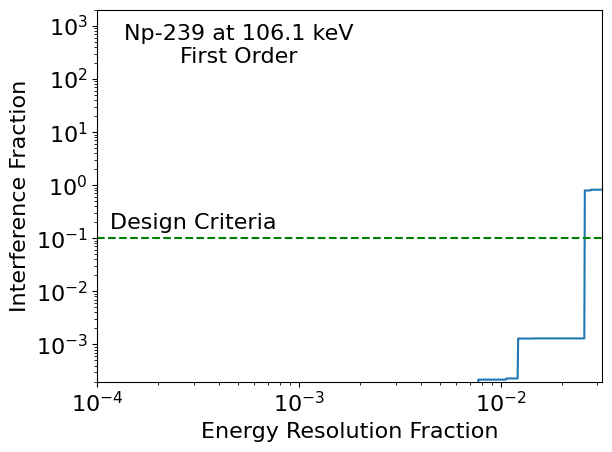

In [18]:
plt.figure()
plt.plot(energy_resolution_grid, pollution_factor_list)
plt.xscale("log")
plt.xlabel("Energy Resolution Fraction")
plt.ylabel("Interference Fraction")
plt.yscale("log")
plt.plot( [energy_resolution_grid[0], energy_resolution_grid[-1]],
        [0.1, 0.1], "g--")
plt.text(3E-4, 1.5E-1, "Design Criteria", ha="center")
plt.ylim(2E-4, 2E3)
plt.xlim(energy_resolution_grid[0], energy_resolution_grid[-1])
label = f"{target_isotope} at {round(first_order_energy,1)} keV"
plt.text(5E-4, 20E1, label+"\nFirst Order", ha="center")
plt.tight_layout()
plt.savefig(f"figures/energy_res_plots/{target_isotope}-{round(first_order_energy,1)}keV_energy_res_1st.png")
plt.show()

# Make Energy Resolution Tradeoff Plot for All Order Diffraction
This plot is the same as above, but if you consider all possible higher order diffraction. Note that higher order diffraction has a much lower efficiency, but here they are treated as being equal. This is mostly done as a check to ensure there aren't significantly brighter gammas that could perhaps interfere via 2nd order diffraction; this could produce Compton scattering and impose some energy resolution requirements.

In [19]:
pollution_factor_list = []


for energy_resolution in energy_resolution_grid:
    sorted_df_list = []
    for order in range(1, 4+1):
        center_energy = first_order_energy*order
        energy_width = center_energy*energy_resolution
        lower_bound = center_energy - energy_width
        upper_bound = center_energy + energy_width
    
        #print(f"\nOrder {order}: {round(center_energy, 2)} ({round(lower_bound,2)} - {round(upper_bound,2)})")
        
        filtered_gammas = example_emission_data[
        (example_emission_data["energy"]<upper_bound) & 
        (lower_bound < example_emission_data["energy"]) &
        (min_threshold < example_emission_data["intensity"]) ]
    
        sorted_gammas = filtered_gammas.sort_values(["intensity"], ascending=False)
    
        sorted_gammas["energy_difference"] = np.abs(sorted_gammas["energy"]-center_energy)/center_energy*100
        sorted_df_list += [sorted_gammas]
    merged_df = pd.concat(sorted_df_list)
    target_index = merged_df[ (np.isclose(merged_df["energy"], first_order_energy) ) & 
        (merged_df["isotope"] == target_isotope) ].index
    most_intense_gamma = merged_df["intensity"].loc[target_index]
    leftover_gamma_df = merged_df.drop(index=target_index)

    noise_gammas = leftover_gamma_df["intensity"].sum()
    pollution_factor = noise_gammas/most_intense_gamma
    pollution_factor_list += [pollution_factor]
    

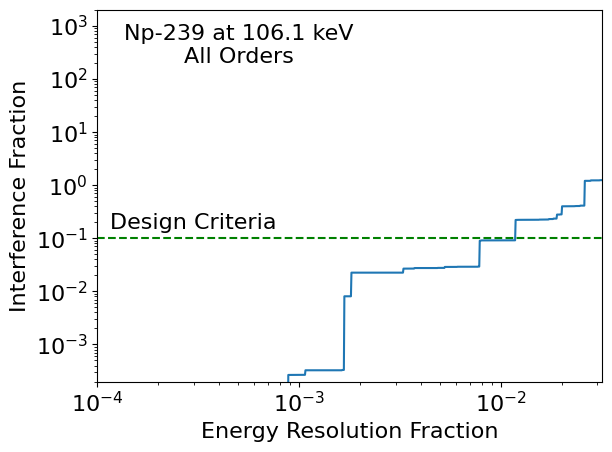

In [21]:
plt.figure()
plt.plot(energy_resolution_grid, pollution_factor_list)
plt.xscale("log")
plt.xlabel("Energy Resolution Fraction")
plt.ylabel("Interference Fraction")
plt.yscale("log")
plt.ylim(2E-4, 2E3)
plt.plot( [energy_resolution_grid[0], energy_resolution_grid[-1]],
        [0.1, 0.1], "g--")
plt.text(3E-4, 1.5E-1, "Design Criteria", ha="center")
plt.xlim(energy_resolution_grid[0], energy_resolution_grid[-1])
label = f"{target_isotope} at {round(first_order_energy,1)} keV"
plt.text(5E-4, 20E1, label+"\nAll Orders", ha="center")
plt.tight_layout()
plt.savefig(f"figures/energy_res_plots/{target_isotope}-{round(first_order_energy,1)}keV_energy_res_all.png")
plt.show()

# Incorporate SHADOW results

This section is used to create plots of the energy filters provided by the SHADOW 3 optical models. 

In [22]:
filter_dict = {}

These code blocks have the filter parameters. Only run the one that you would like to create a plot for.

In [23]:
energy_center = 661.6569
nuclide = "Ba-137m"
nuclide_raw = r"$^{137m}$Ba"

source_efficiency = 6.03145E-08
crystal_efficiency = 0.039336618
detector_efficiency = 0.407304

absolute_efficiency = source_efficiency * detector_efficiency * crystal_efficiency
filter_file = "filter_data/Ba137m_hpge90mm_020fwhm.csv" #"filter_data/ba137m_hpge2x2_5mm_005fwhm.csv"
details = r"440_020fwhm"
crystal_label = r"0.02$\degree$ FWHM"+"\nSi (440)"
fwhm = 37799.9947

plot_max = 8e3

plot_width_modifier =  1.5


In [57]:
energy_center = 661.6569
nuclide = "Ba-137m"
nuclide_raw = r"$^{137m}$Ba"

source_efficiency = 6.03145E-08
crystal_efficiency = 0.024826361
detector_efficiency = 0.407816

absolute_efficiency = source_efficiency * detector_efficiency * crystal_efficiency
filter_file = "filter_data/Ba137m_hpge90mm_0.005fwhm.csv" #"filter_data/ba137m_hpge2x2_5mm_005fwhm.csv"
details = r"440_0.005fwhm"
crystal_label = r"0.005$\degree$ FWHM"+"\nSi (440)"
fwhm = 18599.9842

plot_max = 8e3

plot_width_modifier =  1.5


In [330]:
energy_center = 106.123
nuclide = "Np-239"
nuclide_raw = r"$^{239}$Np"

source_efficiency = 3.63759E-08
crystal_efficiency = 0.061415862
detector_efficiency = 0.961898

absolute_efficiency = source_efficiency * detector_efficiency * crystal_efficiency
filter_file = "filter_data/np239_bgo1x1_5mm_008fwhm.csv" #"filter_data/ba137m_hpge2x2_5mm_005fwhm.csv"
details = r"220_0.008fwhm"
crystal_label = r"0.008$\degree$ FWHM"+"\nSi (220)"
fwhm = 1679.9991

plot_max = 8e3

plot_width_modifier =  2.5


In [311]:
energy_center = 133.5149
nuclide = "Ce-144"
nuclide_raw = r"$^{144}$Ce"

source_efficiency = 2.90069E-08
crystal_efficiency = 0.017890507
detector_efficiency = 0.974808

absolute_efficiency = source_efficiency * detector_efficiency * crystal_efficiency
filter_file = "filter_data/ce144_bgo2x2_5mm_030fwhm.csv" 
details = r"440_0.03fwhm"
crystal_label = r"0.03$\degree$ FWHM"+"\nSi (440)"
fwhm = 2519.9997

plot_max = 8e3

plot_width_modifier =  1.5


In [287]:
energy_center = 414.07
nuclide = "Pm-148m"
nuclide_raw = r"$^{148m}$Pm"

source_efficiency = 5.52063E-08
crystal_efficiency = 0.025868166
detector_efficiency = 0.786457

absolute_efficiency = source_efficiency * detector_efficiency * crystal_efficiency
filter_file = "filter_data/pm148m_bgo2x2_5mm_005fwhm.csv" 
details = r"440_0.005fwhm"
crystal_label = r"0.005$\degree$ FWHM"+"\nSi (440)"
fwhm = 8639.9937

plot_max = 8e3

plot_width_modifier =  2.5


These blocks plot the corresponding filter from above, and then add their data to filter_dict.

In [24]:
overlap_line = fwhm*0.05/1000

processing_energy_width = fwhm/1000*2.5
lower_bound = energy_center-processing_energy_width
upper_bound = energy_center+processing_energy_width

plot_width_fraction = plot_width_modifier*fwhm/energy_center/1000
plot_width = energy_center*plot_width_fraction
lower_plot_bound = energy_center-plot_width
upper_plot_bound = energy_center+plot_width

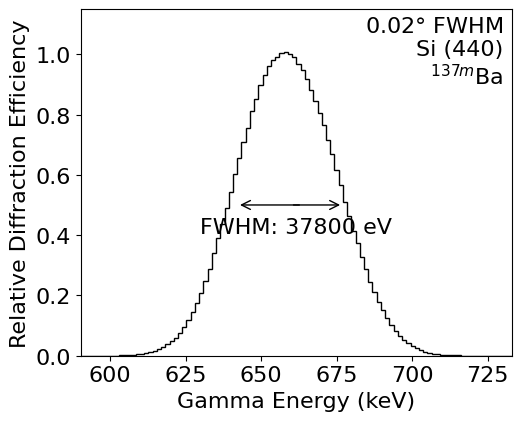

In [30]:
filter_data = read_bandpass_filter(filter_file)




energy=filter_data["energy"]
centroid_index = energy.iloc[(energy-energy_center).abs().argsort()].index[0]

counts = filter_data["counts"]
counts_norm = counts/counts.iloc[centroid_index]

filter_energy = energy
filter_counts = counts_norm

bar_width = (energy[1]-energy[0])

energy_steps = energy - bar_width
energy_steps = energy_steps.tolist()
energy_steps += [energy.iloc[-1]+bar_width]


# Find the x-values where y is approximately half_max_y
# (This step might require more robust search for multiple peaks or noisy data)
indices_above_half_max = np.where(counts_norm >= 0.5)[0]
left_idx = indices_above_half_max[1]
right_idx = indices_above_half_max[-4]


# 5. Calculate FWHM
#fwhm = round(1000*energy.iloc[indices_above_half_max[-1]] - 1000*energy.iloc[indices_above_half_max[0]])




fig, ax = plt.subplots(figsize=(5.5, 4.5) )

# 6. Plot the Data and FWHM

arrow_dict = dict(arrowstyle="->")

#plt.plot([energy.iloc[left_idx], energy.iloc[right_idx]], [0.5, 0.5], linestyle="dotted")
plt.annotate("", (energy.iloc[right_idx], 0.5), (energy_center-overlap_line, 0.5),arrowprops=arrow_dict) 
plt.annotate("", (energy.iloc[left_idx], 0.5), (energy_center+overlap_line, 0.5),arrowprops=arrow_dict) 
#plt.axhline(0.5, color='red', linestyle='--', label='Half Maximum')
#plt.axvline(x_fwhm_left, color='green', linestyle=':', label='FWHM Points')
#plt.axvline(x_fwhm_right, color='green', linestyle=':')
plt.text(0.5, 0.4, f"FWHM: {round(fwhm)} eV", ha="center", va="top", transform = ax.transAxes)
plt.text(0.98, 0.98, f"{crystal_label}\n{nuclide_raw}", ha="right", va="top", transform = ax.transAxes)
plt.stairs(counts_norm, edges=energy_steps, linewidth=1, linestyle="-", edgecolor="black")
plt.xlabel("Gamma Energy (keV)")
plt.xlim(energy.iloc[0], energy.iloc[-1])
plt.ylim(0,1.15)
plt.ylabel("Relative Diffraction Efficiency")
plt.tight_layout()
plt.savefig(f"figures/filter_plots/{nuclide}_{details}_filter.png")
plt.show()

In [31]:
key = f"{nuclide}-{details}"
filter_dict[key] = {}
filter_dict[key]["filter_energy"] = list(filter_energy)
filter_dict[key]["filter_count"] = list(filter_counts)
filter_dict[key]["fwhm"] = fwhm
filter_dict[key]["crystal_label"] = crystal_label
filter_dict[key]["absolute_efficiency"] = absolute_efficiency
filter_dict[key]["detector_efficiency"] = detector_efficiency
filter_dict[key]["crystal_efficiency"] = crystal_efficiency
filter_dict[key]["source_efficiency"] = source_efficiency


This block superimposes the filter over a sample gamma emission spectrum, showing how much gammas are reduced.

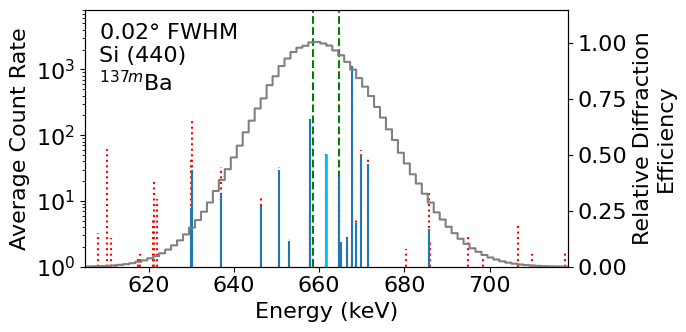

In [32]:
do_legend = False

do_hpge_lines = True
target_count_list = []
noise_count_list = []

hpge_fwhm = 2
hpge_lower = 661.6569 - hpge_fwhm*1.5
hpge_higher = 661.6569 + hpge_fwhm*1.5

gspec_df_filtered = example_emission_data.copy() #gspec_df_list[peb_id].copy()
gspec_df_filtered = gspec_df_filtered[ (lower_bound < gspec_df_filtered["energy"]) &  (gspec_df_filtered["energy"] < upper_bound)]
gspec_df_filtered["efficiency"] = np.interp(gspec_df_filtered["energy"], filter_energy, filter_counts, left=0, right=0)
gspec_df_filtered = gspec_df_filtered.sort_values("energy")
gspec_df_filtered["avg_countrate"] = gspec_df_filtered["intensity"]*absolute_efficiency*gspec_df_filtered["efficiency"]

target_index = (gspec_df_filtered["isotope"] == nuclide) & (np.abs(energy_center - gspec_df_filtered["energy"]) < 0.001) 
target_counts = gspec_df_filtered["avg_countrate"].loc[target_index].sum()


if do_hpge_lines:
    noise_index = (~target_index) & (hpge_lower < gspec_df_filtered["energy"]) & (gspec_df_filtered["energy"] < hpge_higher)
    noise_counts = gspec_df_filtered["avg_countrate"].loc[noise_index].sum()
else:
    noise_counts = gspec_df_filtered["avg_countrate"].loc[~target_index].sum()

target_count_list += [target_counts]
noise_count_list += [noise_counts]

abs_weighted = absolute_efficiency*gspec_df_filtered["intensity"]
filter_weighted = abs_weighted*gspec_df_filtered["efficiency"]

try:
    max_weighted = max(abs_weighted)
except:
    max_weighted = 0
fig, ax1 = plt.subplots(figsize=(7,3.6) )
ln1 = ax1.vlines(gspec_df_filtered["energy"], 1e-11, abs_weighted, linestyle="dotted", color="red", label="Emitted")
ln2 = ax1.vlines(gspec_df_filtered["energy"], 0, filter_weighted, label="Measured")


ax1.vlines(energy_center, 0, target_counts, color="#00c3ff", linewidth=2, zorder=10)

if do_hpge_lines:
    ln4 = ax1.vlines([hpge_lower, hpge_higher], 0, plot_max, linestyle="dashed", color="green", label=r"1.5$\times$"+"HPGe\nFWHM", zorder=-1)

ax1.set_xlim(lower_plot_bound, upper_plot_bound)
ax1.set_ylim(1, plot_max)
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Average Count Rate")
ax1.set_yscale("log")

ax2 = ax1.twinx() 
ln3 = ax2.plot(filter_energy, filter_counts, color="gray", label="Filter")
ax2.set_ylabel("Relative Diffraction\nEfficiency")
ax2.set_ylim(0,1.15)

if do_hpge_lines:
    lns = [ln1, ln2, ln4]
else:
    lns = [ln1, ln2]
labs = [l.get_label() for l in lns]
lns += [ln3[0]]
labs += [ln3[0].get_label()]


plt.tight_layout()
bu_str = f"{crystal_label}\n{nuclide_raw}"
ax1.text(0.03, 0.95, bu_str, ha='left', verticalalignment='top', transform = ax1.transAxes)
if do_legend:
    ax1.legend(lns, labs, loc="upper right")
    plt.savefig(f"figures/filtered_spectra_plots/filtered_spectrum_{nuclide}_{details}_legend.png")
else:
    plt.savefig(f"figures/filtered_spectra_plots/filtered_spectrum_{nuclide}_{details}.png")
plt.show()



In [34]:
filtered_sorted = gspec_df_filtered[gspec_df_filtered["avg_countrate"]>1]
filtered_sorted = filtered_sorted.loc[filtered_sorted["energy"].sort_values(ascending=True).index ]


Write a GADRAS .gam file that can be used to see what a BCD-filtered spectrum would look like in different detectors. GADRAS use isn't included in this notebook.

In [35]:
file_name = f"{details}_gadras.gam"
filtered_copy = filtered_sorted[ ["energy", "avg_countrate"] ].copy()

num_lens = len(filtered_copy)

with open(file_name, "w") as f:
    f.write(f"{num_lens}  {num_lens}")
    for index, row in filtered_copy.iterrows():
        line_str = f"\n   {round(row.values[0], 4)}    {round(row.values[1], 4)} "
        f.write(line_str)
    

In [36]:
hpge_filterable_peaks = [
(661.6569, "Ba-137m"),
(667.7140, "I-132"),
(657.9400, "Nb-97"),
(664.5709, "Ce-143"),
(636.9890, "I-131")
]

In [37]:
filter_dict['Ba-137m-440_0.02fwhm']["energy_center"]=661.6569
filter_dict['Ba-137m-440_0.005fwhm']["energy_center"]=661.6569
filter_dict['Ce-144-440_0.03fwhm']["energy_center"]=133.5149
filter_dict['Pm-148m-440_0.005fwhm']["energy_center"]=414.07
filter_dict['Np-239-220_0.008fwhm']["energy_center"]=106.123

KeyError: 'Ba-137m-440_0.02fwhm'

Write all of the filter data to a dictionary. Note, the completed one already has been included with this notebook, so this step has been commented out unless you decide to recreate them.

In [38]:
#with open(f"filter_data/filter_dict.json","w") as f:
#    f.write(json.dumps(filter_dict))

# Apply Filters
Now, take the BCD spectrometer filter data contained in filter_dict and apply it to the entire gamma spectra for all pebbles. This requires you to have run the decay calculations in Serpent from above; otherwise, ensure that "serpent_bcd_spectrometer_average_countrates.csv" is located in the root directory.

In [39]:
with open(f"filter_data/filter_dict.json","r") as f:
    filter_dict = json.load(f)


In [40]:
top4_params = {'bootstrap': True, 
                   'ccp_alpha': 0.0, 
                   'max_depth': 10, 
                   'max_features': 1.0, 
                   'max_leaf_nodes': None, 
                   'max_samples': None, 
                   'min_impurity_decrease': 0.0, 
                   'min_samples_leaf': 1, 
                   'min_samples_split': 2, 
                   'min_weight_fraction_leaf': 0.0, 
                   'n_estimators': 400, 
                   'n_jobs': 8,
                   'oob_score': False, 
                   'random_state': 0, 
                   'verbose': 0, 
                   'warm_start': False}


In [41]:
target_raw = pd.read_csv("top4_targets.csv", index_col=0)

In [46]:
directory = "decay_runs"
count_data = []

# Recall that La-140 counts are assumed to easily be acquired with a common 
# scintillator since they have the highest energy and one of the highest 
# intensity peaks
la140_setup = {"type": "NaI",
               "distance": 3.00,
               "energy": 1596.209,
               "intrinsic_efficiency": 0.1,
               "collimator_diameter": 0.5 / 100
                }


emissions_data = []


day = "1.5"
num_pebs = len(target_raw)
for i in range(num_pebs):
    if i%100 == 0:
        print(f"{i} of {num_pebs}")
    peb_spectrum = read_single_gspec_individual(f"{directory}/decay_{i}_step2_{day}d.serpent_gsrc.m")
    emissions_data += [peb_spectrum]
    
    peb_spectrum = peb_spectrum.sort_values("energy")
    peb_data = {}

    

    for key in filter_dict.keys():
        gspec_df_filtered = peb_spectrum.copy() 
        
        splitkey = key.split("-")
        current_filter = filter_dict[key]
        if "Ba" in key:
            is_hpge = True
        else:
            is_hpge = False
        nuclide = splitkey[0]+"-"+splitkey[1]
        absolute_efficiency = current_filter["absolute_efficiency"]
        filter_energy = current_filter["filter_energy"]
        filter_counts = current_filter["filter_count"]
        energy_center = current_filter["energy_center"]

        lower_bound = filter_energy[0]
        upper_bound = filter_energy[-1]
        gspec_df_filtered = gspec_df_filtered[ (lower_bound < gspec_df_filtered["energy"]) &  (gspec_df_filtered["energy"] < upper_bound)]
        gspec_df_filtered["efficiency"] = np.interp(gspec_df_filtered["energy"], filter_energy, filter_counts, left=0, right=0)
        gspec_df_filtered = gspec_df_filtered.sort_values("energy")
        gspec_df_filtered["avg_countrate"] = gspec_df_filtered["intensity"]*absolute_efficiency*gspec_df_filtered["efficiency"]

        #gspec_df_filtered["sampled_counts"] = np.random.poisson(gspec_df_filtered["avg_countrate"]*measurement_time)
        
        target_index = (gspec_df_filtered["isotope"] == nuclide) & (np.abs(energy_center - gspec_df_filtered["energy"]) < 0.001) 
        target_counts = gspec_df_filtered["avg_countrate"].loc[target_index].sum()


        if is_hpge:
            fwhm = key.split("_")[-1]
            for peak_ind in range(len(hpge_filterable_peaks)):
                hpge_peak_energy = hpge_filterable_peaks[peak_ind][0]
                hpge_peak_nuclide = hpge_filterable_peaks[peak_ind][1]
                hpge_index = np.abs(hpge_peak_energy - gspec_df_filtered["energy"]) < 0.001
                peak_label = f"hpge_{hpge_peak_nuclide}_{round(hpge_peak_energy,2)}_{fwhm}"
                peb_data[peak_label] = gspec_df_filtered["avg_countrate"].loc[hpge_index].sum()
        else:
            
            peb_data[f"current_{nuclide}_{energy_center}"] = gspec_df_filtered["avg_countrate"].sum()
        

    la140_emissions = peb_spectrum["intensity"].loc[( np.abs(peb_spectrum["energy"]-1596.209) < 0.1) & (peb_spectrum["isotope"] == "La-140")]
    la140_rate, sampled_counts, unc = simulate_simple_counts(la140_emissions, la140_setup["distance"], la140_setup["collimator_diameter"], intrinsic_efficiency = la140_setup["intrinsic_efficiency"], print_results = False)      
    peb_data["La140_scintillator"] = la140_rate.iloc[0]
    
    count_data += [peb_data]


100 of 15744


In [28]:
gamma_data = pd.DataFrame(count_data)
gamma_data = gamma_data.fillna(0.0)
display(gamma_data)
gamma_data.to_csv("serpent_bcd_spectrometer_average_countrates.csv")

,hpge_Ba-137m_661.66_0.02fwhm,hpge_I-132_667.71_0.02fwhm,hpge_Nb-97_657.94_0.02fwhm,hpge_Ce-143_664.57_0.02fwhm,hpge_I-131_636.99_0.02fwhm,hpge_Ba-137m_661.66_0.005fwhm,hpge_I-132_667.71_0.005fwhm,hpge_Nb-97_657.94_0.005fwhm,hpge_Ce-143_664.57_0.005fwhm,hpge_I-131_636.99_0.005fwhm,current_Ce-144_133.5149,current_Pm-148m_414.07,current_Np-239_106.123,La140_scintillator
0,57.750539,1372.663475,222.084493,29.305579,14.748214,37.117227,751.357467,132.007641,18.308937,0.618969,14.263881,27.892732,5874.210805,40116.171552
1,28.233589,1663.154565,287.939133,39.242282,18.163017,18.146195,910.364139,171.151822,24.516987,0.762285,11.986842,25.587492,4422.641308,56863.039385
2,32.605409,1649.409750,254.380082,36.602507,18.675173,20.956036,902.840613,151.204229,22.867762,0.783780,12.771371,21.518080,3217.579951,57396.695057
3,33.354118,1802.046012,328.410554,43.662696,18.824982,21.437244,986.389420,195.208147,27.278682,0.790067,13.100003,28.668550,5843.549867,56510.270958
4,43.220254,1533.649880,262.782486,35.386488,16.189544,27.778373,839.476908,156.198641,22.108043,0.679460,13.978782,28.925226,4505.112182,46989.747806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15739,58.304183,1362.782206,224.478424,29.404888,14.634409,37.473064,745.948738,133.430600,18.370982,0.614192,15.025738,25.862104,4995.544191,40234.005003
15740,18.732434,1853.920085,316.413616,44.083426,20.464570,12.039645,1014.783831,188.077134,27.541537,0.858879,9.131444,23.755541,4754.726354,64831.709147
15741,27.775043,1811.028015,299.476645,42.047457,19.432164,17.851480,991.305916,178.009751,26.269546,0.815550,11.980669,25.945095,5603.589371,59812.630917
15742,18.280585,2128.407263,396.044468,53.111638,22.322971,11.749235,1165.030410,235.409934,33.181998,0.936874,9.093623,29.558594,4258.661926,68842.541757


# Measurement Regression and Analysis
You can skip the data generation and start from here.

In [48]:
target_raw = pd.read_csv("top4_targets.csv", index_col=0)
count_rates = pd.read_csv("serpent_bcd_spectrometer_average_countrates.csv", index_col=0)
measurement_time = 20.0
display(count_rates[:5])


sampled_counts = count_rates*measurement_time

sampled_counts = sampled_counts.map(lambda x: np.random.poisson(x))
display(sampled_counts[:5])

,hpge_Ba-137m_661.66_0.02fwhm,hpge_I-132_667.71_0.02fwhm,hpge_Nb-97_657.94_0.02fwhm,hpge_Ce-143_664.57_0.02fwhm,hpge_I-131_636.99_0.02fwhm,hpge_Ba-137m_661.66_0.005fwhm,hpge_I-132_667.71_0.005fwhm,hpge_Nb-97_657.94_0.005fwhm,hpge_Ce-143_664.57_0.005fwhm,hpge_I-131_636.99_0.005fwhm,current_Ce-144_133.5149,current_Pm-148m_414.07,current_Np-239_106.123,La140_scintillator
0,57.750539,1372.663475,222.084493,29.305579,14.748214,37.117227,751.357467,132.007641,18.308937,0.618969,14.263881,27.892732,5874.210805,40116.171552
1,28.233589,1663.154565,287.939133,39.242282,18.163017,18.146195,910.364139,171.151822,24.516987,0.762285,11.986842,25.587492,4422.641308,56863.039385
2,32.605409,1649.409750,254.380082,36.602507,18.675173,20.956036,902.840613,151.204229,22.867762,0.783780,12.771371,21.518080,3217.579951,57396.695057
3,33.354118,1802.046012,328.410554,43.662696,18.824982,21.437244,986.389420,195.208147,27.278682,0.790067,13.100003,28.668550,5843.549867,56510.270958
4,43.220254,1533.649880,262.782486,35.386488,16.189544,27.778373,839.476908,156.198641,22.108043,0.679460,13.978782,28.925226,4505.112182,46989.747806


,hpge_Ba-137m_661.66_0.02fwhm,hpge_I-132_667.71_0.02fwhm,hpge_Nb-97_657.94_0.02fwhm,hpge_Ce-143_664.57_0.02fwhm,hpge_I-131_636.99_0.02fwhm,hpge_Ba-137m_661.66_0.005fwhm,hpge_I-132_667.71_0.005fwhm,hpge_Nb-97_657.94_0.005fwhm,hpge_Ce-143_664.57_0.005fwhm,hpge_I-131_636.99_0.005fwhm,current_Ce-144_133.5149,current_Pm-148m_414.07,current_Np-239_106.123,La140_scintillator
0,1113,27454,4501,559,288,755,14955,2483,340,13,275,524,117688,803987
1,541,33130,5691,798,384,381,18249,3421,448,15,214,512,88696,1135498
2,651,32654,5008,771,347,454,17918,3022,456,13,263,401,63611,1146760
3,676,35882,6535,848,375,432,19696,3891,601,21,266,584,116842,1130541
4,874,30863,5248,718,304,530,16734,3196,495,18,265,550,90119,939955


In [49]:
used_fwhm = "0.02fwhm"

drop_fwhm = "0.005fwhm"
drop_columns = []
for header in sampled_counts.columns:
    if drop_fwhm in header:
        drop_columns += [header]

In [50]:
gamma_data = sampled_counts.drop(columns=drop_columns)

Standardize the BCD gamma count rate data and the same target variables as before.

In [53]:
train_split = 0.8

data_raw = gamma_data


def standardize(raw_data, mean=None, std=None, axis=0):
    if mean is None:
        mean = np.mean(raw_data, axis = axis)
    if std is None:
        std = np.std(raw_data, axis = axis)
        std[ std==0 ] = 0.1
    result = (raw_data - mean) / std
    return result, mean, std

def unstandardize(standardized_data, mean, std):
    raw_data = (standardized_data*std)+mean
    return raw_data

num_data, _ = np.shape(data_raw)
training_size = int(num_data*train_split)
testing_size = num_data - training_size
data_indices = np.arange(num_data)
training_indices = np.random.choice(num_data, training_size, replace=False)
testing_indices = data_indices[np.in1d(data_indices, training_indices, invert=True)]

top4_training_target, top4_target_mean, top4_target_std = standardize(target_raw.iloc[training_indices])
top4_training_data, top4_data_mean, top4_data_std = standardize(data_raw.iloc[training_indices])

top4_testing_target, _, _  = standardize(target_raw.iloc[testing_indices], mean=top4_target_mean, std=top4_target_std)
top4_testing_data, _, _  = standardize(data_raw.iloc[testing_indices], 
                                         mean=top4_data_mean, std=top4_data_std)


# Model creation and performance assessment
RFR models are trained on the synthetic BCD spectrometer measurements with the pebble history parameters as output.

In [52]:

serpent_models = {}
serpent_models_r2_vals = {}

result_table = {}
for target_label in top4_training_target.columns:
    rfr_model = RandomForestRegressor(random_state=0)
    rfr_model.set_params(**top4_params)
    rfr_model.fit(top4_training_data, top4_training_target[target_label])
    serpent_models[target_label] = rfr_model
    rfr_model_predict = rfr_model.predict(top4_testing_data)
    r2_score_val = round(r2_score(rfr_model_predict, top4_testing_target[target_label]),4)
    serpent_models_r2_vals[target_label] = r2_score_val
    mape_score_val = round(mean_absolute_percentage_error(rfr_model_predict, top4_testing_target[target_label])*100,1)
    print(f"{target_label} rfr score (ba137m {used_fwhm}) - r^2: {r2_score_val}, MAPE: {mape_score_val}")
    result_table[target_label] = {"r2_score":r2_score_val,
                                  "mape_score":mape_score_val}



U-235 rfr score (ba137m 0.02fwhm) - r^2: 0.9957, MAPE: 36.9
U-238 rfr score (ba137m 0.02fwhm) - r^2: 0.9802, MAPE: 54.3
Pu-239 rfr score (ba137m 0.02fwhm) - r^2: 0.8901, MAPE: 133.2
Np-239 rfr score (ba137m 0.02fwhm) - r^2: 0.9997, MAPE: 5.9
avg_r_dist rfr score (ba137m 0.02fwhm) - r^2: 0.6772, MAPE: 229.2
passes rfr score (ba137m 0.02fwhm) - r^2: 0.9868, MAPE: 27.4
residence_time rfr score (ba137m 0.02fwhm) - r^2: 0.987, MAPE: 50.5
burnup rfr score (ba137m 0.02fwhm) - r^2: 0.9947, MAPE: 25.7
fima rfr score (ba137m 0.02fwhm) - r^2: 0.9948, MAPE: 14.3
pass_residence_time rfr score (ba137m 0.02fwhm) - r^2: 1.0, MAPE: 0.0
pass_avg_r_dist rfr score (ba137m 0.02fwhm) - r^2: 0.8948, MAPE: 178.1
pass_fima rfr score (ba137m 0.02fwhm) - r^2: 0.9946, MAPE: 37.3
pass_burnup rfr score (ba137m 0.02fwhm) - r^2: 0.9942, MAPE: 28.3
integrated_flux_pebbles_thermal rfr score (ba137m 0.02fwhm) - r^2: 0.987, MAPE: 30.7
integrated_flux_pebbles_fast rfr score (ba137m 0.02fwhm) - r^2: 0.979, MAPE: 50.3
integ

In [55]:
with open(f"serpent_bcd_spectrometer_{used_fwhm}fwhm_results.json", 'w') as fp:
    json.dump(result_table, fp)

# Confusion Matrix generation
The probability of correctly classifying a spent burnup pebble is determined by pass and shown in a confusion matrix.

Pass: 7
True positive: 0.0%
False positive: 0.7%
True negative: 99.3%
False negative: 0.0%


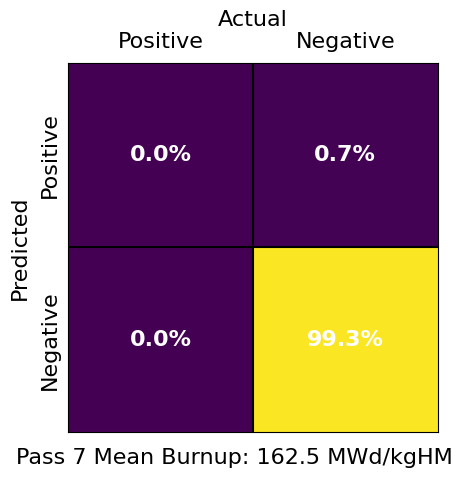

Pass: 8
True positive: 24.3%
False positive: 10.9%
True negative: 56.3%
False negative: 8.4%


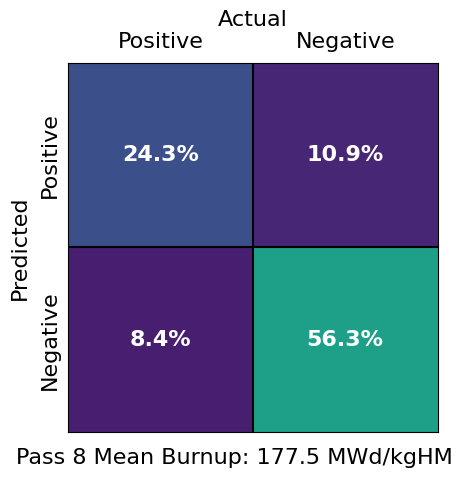

Pass: 9
True positive: 92.8%
False positive: 1.2%
True negative: 1.9%
False negative: 4.1%


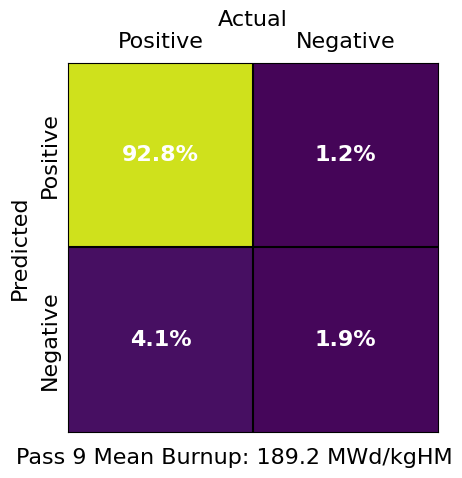

Pass: 10
True positive: 98.2%
False positive: 0.0%
True negative: 0.0%
False negative: 1.8%


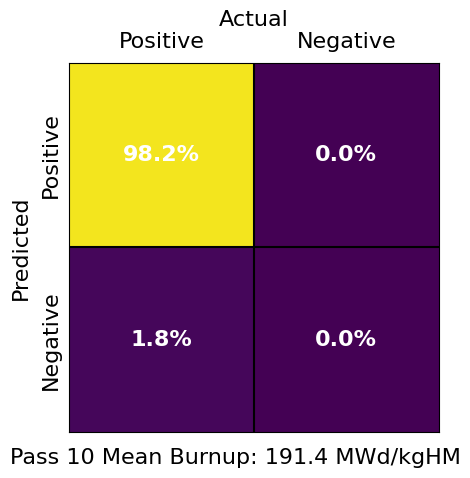

In [57]:
burnup_threshold = 180

for pass_num in [7,8,9,10]:
    print(f"Pass: {pass_num}")
    last_pass_id = target_raw["passes"] == pass_num
    last_pass_data = data_raw[last_pass_id]
    last_pass_target = target_raw[last_pass_id]
    pass_average_burnup = round(last_pass_target["burnup"].mean(), 1)
    
    last_pass_std_data, _, _  = standardize(last_pass_data, 
                                             mean=top4_data_mean, std=top4_data_std)
    
    
    
    
    last_pass_std_predictions = serpent_models["burnup"].predict(last_pass_std_data)
    last_pass_burnup_predictions = unstandardize(last_pass_std_predictions, top4_target_mean["burnup"], top4_target_std["burnup"])
    last_pass_burnup_actual = last_pass_target["burnup"]
    
    predicted_choice_list = last_pass_burnup_predictions > burnup_threshold
    correct_choice_list = last_pass_burnup_actual > burnup_threshold
    correct_choice_list = correct_choice_list.reset_index(drop=True)
    
    true_negative = 0
    false_negative = 0
    true_positive = 0
    false_positive = 0
    num_samples = len(last_pass_burnup_predictions)
    
    for i in range(num_samples):
        predicted_choice = predicted_choice_list[i]
        correct_choice = correct_choice_list.iloc[i]
        if predicted_choice == True and correct_choice == True:
            true_positive += 1
        if predicted_choice == False and correct_choice == False:
            true_negative += 1
        if predicted_choice == True and correct_choice == False:
            false_positive += 1
        if predicted_choice == False and correct_choice == True:
            false_negative += 1
    
    
    TP = round(true_positive/num_samples*100,1)
    FP = round(false_positive/num_samples*100,1)
    TN = round(true_negative/num_samples*100,1)
    FN = round(false_negative/num_samples*100,1)
    print(f"True positive: {TP}%")
    print(f"False positive: {FP}%")
    print(f"True negative: {TN}%")
    print(f"False negative: {FN}%")


    confusion_matrix = np.array([[TP, FP], [FN, TN]])
    fig,ax = plt.subplots(1)
    ax.imshow(confusion_matrix, vmin=0, vmax=100, 
              extent=[0, 1, 0, 1], 
              origin="upper")
    ax.set_xticks([])
    ax.xaxis.tick_top()
    plt.text(0.75, 0.25, str(TN)+"%", ha="center", va="center", color="white", fontweight="bold")
    plt.text(0.25, 0.75, str(TP)+"%", ha="center", va="center", color="white", fontweight="bold")
    plt.text(0.75, 0.75, str(FP)+"%", ha="center", va="center", color="white", fontweight="bold")
    plt.text(0.25, 0.25, str(FN)+"%", ha="center", va="center", color="white", fontweight="bold")
    plt.text(0.45, -0.07, f"Pass {pass_num} Mean Burnup: {pass_average_burnup} MWd/kgHM", 
             ha="center", va="center", color="black")
    ax.set_yticks([])
    plt.text(-0.05, 0.25, "Negative", va="center", ha="center", rotation="vertical")
    plt.text(-0.05, 0.75, "Positive", va="center", ha="center", rotation="vertical")
    plt.text(0.25, 1.04, "Positive", ha="center")
    plt.text(0.75, 1.04, "Negative", ha="center")
    plt.text(0.5, 1.10, "Actual", ha="center")
    #plt.text(0.4, 1.18, f"Pass {pass_num} Burnup Threshold Accuracy", ha="center", fontweight="bold")
    plt.text(-0.13, 0.5, "Predicted", ha="center", va="center", rotation="vertical")
    plt.plot((0.5,0.5),(0,1.0),"black")
    plt.plot((0,1),(0.5,0.5),"black")
    plt.savefig(f"figures/confusion_matrices/{used_fwhm}fwhm_confusion_pass{pass_num}_matrix.png")
    plt.show()

# Misc Plots

In [24]:
last_pass_path = history_dataset[225]["pass_avg_r_dist"]
last_pass_burnup = history_dataset[225]["pass_fima"]

[ 30.      72.4264  94.3879 111.9615]


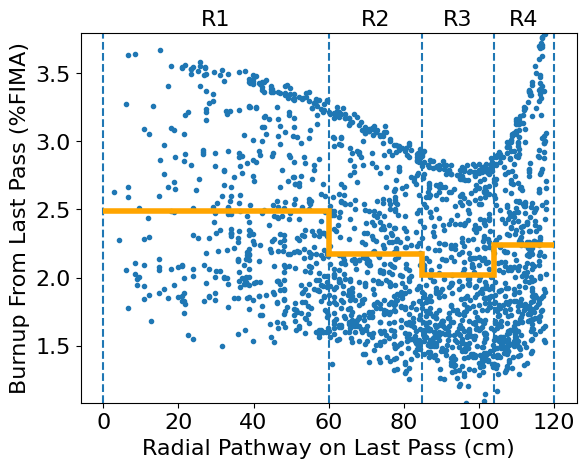

In [46]:
y_min = min(last_pass_burnup)*100
y_max = max(last_pass_burnup)*100
radial_boundaries = np.array([0.0000, 60.0000, 84.8528, 103.9230, 120.0000])
radial_avgs = []

for r in range(len(radial_boundaries)-1):
    ind = (last_pass_path > radial_boundaries[r])&(last_pass_path < radial_boundaries[r+1])
    radial_avgs += [np.mean(last_pass_burnup[ind])*100]
center_values = (radial_boundaries[:-1]+radial_boundaries[1:])/2
print(center_values)
plt.figure()
plt.plot(last_pass_path, last_pass_burnup*100, '.')
plt.xlabel("Radial Pathway on Last Pass (cm)")
plt.ylabel("Burnup From Last Pass (%FIMA)")
plt.vlines(radial_boundaries, ymin=y_min, ymax=y_max, linestyles="dashed")
plt.stairs(radial_avgs, radial_boundaries, color="orange", linewidth=4, zorder=4, baseline=None)
plt.ylim(y_min, y_max)
y_offset = 3.85
plt.text(center_values[0], y_offset, "R1", ha="center")
plt.text(center_values[1], y_offset, "R2", ha="center")
plt.text(center_values[2], y_offset, "R3", ha="center")
plt.text(center_values[3], y_offset, "R4", ha="center")
plt.show()